# LFADS Ecog prediction - Performance table
Michael Nolan

2020.10.27

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import site
site.addsitedir(os.path.curdir + '\..')

In [2]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------

def prep_model(model_name, data_dict, data_suffix, batch_size, device, hyperparams, input_dims=None):
    if model_name == 'lfads_ecog':
        # train_dl, valid_dl, input_dims, plotter = prep_data(data_dict=data_dict, data_suffix=data_suffix, batch_size=batch_size, device=device)
        if not input_dims:
            input_dims = data_dict['test_ecog_fl0u10'].shape[-1]
        model, objective = prep_lfads_ecog(input_dims = input_dims,
                                      hyperparams=hyperparams,
                                      device= device,
                                      dtype=data_dict['test_ecog_fl0u10'].dtype,
                                      dt= data_dict['dt']
                                      )
    return model

#-------------------------------------------------------------------
#-------------------------------------------------------------------

def prep_lfads_ecog(input_dims, hyperparams, device, dtype, dt):
    from objective import LFADS_Loss, LogLikelihoodGaussian
    from lfads import LFADS_Ecog_SingleSession_Net

    model = LFADS_Ecog_SingleSession_Net(input_size           = input_dims,
                                    factor_size          = hyperparams['model']['factor_size'],
                                    g_encoder_size       = hyperparams['model']['g_encoder_size'],
                                    c_encoder_size       = hyperparams['model']['c_encoder_size'],
                                    g_latent_size        = hyperparams['model']['g_latent_size'],
                                    u_latent_size        = hyperparams['model']['u_latent_size'],
                                    controller_size      = hyperparams['model']['controller_size'],
                                    generator_size       = hyperparams['model']['generator_size'],
                                    prior                = hyperparams['model']['prior'],
                                    clip_val             = hyperparams['model']['clip_val'],
                                    dropout              = hyperparams['model']['dropout'],
                                    do_normalize_factors = hyperparams['model']['normalize_factors'],
                                    max_norm             = hyperparams['model']['max_norm'],
                                    device               = device).to(device)
    
    loglikelihood = LogLikelihoodGaussian()

    objective = LFADS_Loss(loglikelihood            = loglikelihood,
                           loss_weight_dict         = {'kl': hyperparams['objective']['kl'], 
                                                       'l2': hyperparams['objective']['l2']},
                           l2_con_scale             = hyperparams['objective']['l2_con_scale'],
                           l2_gen_scale             = hyperparams['objective']['l2_gen_scale']).to(device)

    return model, objective

#-------------------------------------------------------------------
#-------------------------------------------------------------------
    
def prep_data(data_dict, data_suffix, batch_size, device, input_size=None):
    train_data  = torch.Tensor(data_dict['train_%s'%data_suffix])
    valid_data  = torch.Tensor(data_dict['valid_%s'%data_suffix])
    
    num_trials, num_steps, _ = train_data.shape
    if not input_size: # very hacky, I apologize to the lord
        input_size = train_data.shape(-1)
    
    train_ds    = EcogTensorDataset(train_data,device=device)
    valid_ds    = EcogTensorDataset(valid_data,device=device)
    
    train_dl    = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle=True)
    valid_dl    = torch.utils.data.DataLoader(valid_ds, batch_size = batch_size)
    
    TIME = torch._np.arange(0, num_steps*data_dict['dt'], data_dict['dt'])
    
    train_truth = {}
    if 'train_rates' in data_dict.keys():
        train_truth['rates'] = data_dict['train_rates']
    if 'train_latent' in data_dict.keys():
        train_truth['latent'] = data_dict['train_latent']
    if 'valid_spikes' in data_dict.keys():
        train_truth['spikes'] = data_dict['train_spikes']
        
    valid_truth = {}
    if 'valid_rates' in data_dict.keys():
        valid_truth['rates'] = data_dict['valid_rates']
    if 'valid_latent' in data_dict.keys():
        valid_truth['latent'] = data_dict['valid_latent']
    if 'valid_spikes' in data_dict.keys():
        valid_truth['spikes'] = data_dict['valid_spikes']

    plotter = None
    # plotter = {'train' : Plotter(time=TIME, truth=train_truth),
    #            'valid' : Plotter(time=TIME, truth=valid_truth)}
    
    return train_dl, valid_dl, input_size, plotter

#-------------------------------------------------------------------
#-------------------------------------------------------------------

from torch.utils.data.dataset import Dataset
class EcogTensorDataset(Dataset):
    r"""Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Arguments:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """

    def __init__(self, *tensors, device='cpu'):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.device = device

    def __getitem__(self, index):
        return tuple(tensor[index].to(self.device) for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)

#-------------------------------------------------------------------
#-------------------------------------------------------------------

import h5py
def read_data(data_fname,keys):
    
    """ Read saved data in HDF5 format.

    Args:
        data_fname: The filename of the file from which to read the data.
    Returns:
        A dictionary whose keys will vary depending on dataset (but should
        always contain the keys 'train_data' and 'valid_data') and whose
        values are numpy arrays.
    """
    try:
        with h5py.File(data_fname, 'r') as hf:
            data_dict = {k: np.array(v) for k, v in hf.items() if k in keys}
            return data_dict
    except IOError:
        print("Cannot open %s for reading." % data_fname)
        raise

In [3]:
def compute_prediction_metrics(test_data,pred,pred_window_T,bin_T,p_lim=[2.5, 97.5],srate=250):
    n_trial, n_sample, n_ch = test_data.shape
    time = np.arange(pred_window_T*srate)/srate
    bin_T_left_edge = np.arange(pred_window_T,step=bin_T)
    bin_T_right_edge = bin_T_left_edge + bin_T
    n_time_bin = len(bin_T_left_edge)
    mae, rmse, rpe = compute_prediction_error(test_data, pred)
    mae_bin = np.empty((n_trial,n_time_bin))
    rmse_bin = np.empty((n_trial,n_time_bin))
    rpe_bin = np.empty((n_trial,n_time_bin))
    for tb_idx in range(n_time_bin):
        bin_idx = np.logical_and(time >= bin_T_left_edge[tb_idx], time < bin_T_right_edge[tb_idx])
        mae_bin[:,tb_idx], rmse_bin[:,tb_idx], rpe_bin[:,tb_idx] = compute_prediction_error(test_data[:,bin_idx,:],pred[:,bin_idx,:])
    # get stats from sample distributions
    stat_dict = {
        'mae_mean': mae.mean(),
        'mae_95ci': np.percentile(mae,p_lim),
        'mae_bin_mean': mae_bin.mean(axis=0),
        'mae_bin_95ci': np.percentile(mae_bin,p_lim,axis=0),
        'rmse_mean': rmse.mean(),
        'rmse_95ci': np.percentile(rmse,p_lim),
        'rmse_bin_mean': rmse_bin.mean(axis=0),
        'rmse_bin_95ci': np.percentile(rmse_bin,p_lim,axis=0),
        'rpe_mean': rpe.mean(),
        'rpe_95ci': np.percentile(rpe,p_lim),
        'rpe_bin_mean': np.nanmean(rpe_bin,axis=0),
        'rpe_bin_95ci': np.nanpercentile(rpe_bin,p_lim,axis=0),
        # 'corr_mean': np.tanh(np.arctanh(corr).mean(axis=0)),
        # 'corr_95ci': np.percentile(corr,p_lim,axis=0),
        # 'corr_bin_mean': np.tanh(np.arctanh(corr_bin).mean(axis=0)),
        # 'corr_bin_95ci': np.percentile(corr_bin,p_lim,axis=0)
    }
    return stat_dict, bin_T_left_edge

def compute_prediction_error(trg,pred):
    err = trg - pred
    mae = np.abs(err).mean(axis=(1,2))
    rmse = np.sqrt((err**2).mean(axis=(1,2)))
    trg_std = trg.std(axis=1)
    rpe = (err.std(axis=1)/trg_std).mean(axis=-1)
    rpe[np.isinf(rpe)] == np.nan
    return mae, rmse, rpe

In [4]:
hyperparameter_path = "C:\\Users\\mickey\\aoLab\\code\\hierarchical_lfads\\hyperparameters\\ecog\\lfads_ecog_3.yaml"
data_path = "D:\\Users\\mickey\\Data\\datasets\\ecog\\goose_wireless\\gw_250_fl0u10"
data_suffix = "ecog_fl0u10"
model_name = "lfads_ecog"
batch_size = 1000
device = 'cpu'

In [5]:
from utils import  load_parameters
hyperparams = load_parameters(hyperparameter_path)
data_dict   = read_data(data_path,keys = ['test_ecog_fl0u10','dt'])
model= prep_model(model_name = model_name,
                                        data_dict = data_dict,
                                        data_suffix = data_suffix,
                                        batch_size = batch_size,
                                        device = device,
                                        hyperparams = hyperparams)

In [6]:
model_path = "D:\\Users\\mickey\\Data\\models\\pyt\\lfads\\gw_250_fl0u10\\lfads_ecog\\cenc0_cont0_fact64_genc128_gene128_glat128_ulat0_orion-\\checkpoints\\best.pth"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [7]:
n_test_samples = data_dict['test_ecog_fl0u10'].shape[0]
test_data = torch.tensor(data_dict['test_ecog_fl0u10']).float()
model.eval()
with torch.no_grad():
    recon, (factors, inputs) = model(test_data)


In [8]:
recon['data'].shape

torch.Size([12018, 250, 42])

In [9]:
mse = np.mean((recon['data'].numpy() - test_data.numpy())**2,axis=(1,2))
rmse = np.sqrt(mse)
mae = np.abs(recon['data'].numpy() - test_data.numpy()).mean(axis=(1,2))
trg_std = np.std(test_data.numpy(), axis=(1,2))
trg_std[trg_std < 0.1] = np.nan
rpe = rmse/trg_std

In [10]:
np.sum(trg_std == 0)

0

In [11]:
# # compute binned prediction metrics
# stat_dict, bin_T_left_edge = compute_prediction_metrics(test_data,recon,1,0.1,srate=250)

In [12]:
result_dict = {
    'mse_mean': mse.mean(),
    'mse_95CI': np.percentile(mse,[2.5,97.5]),
    'rmse_mean': rmse.mean(),
    'rmse_95CI': np.percentile(rmse,[2.5,97.5]),
    'mae_mean': mae.mean(),
    'mae_95CI': np.percentile(mae,[2.5,97.5]),
    'rpe_mean': np.nanmean(rpe),
    'rpe_95CI': np.nanpercentile(rmse,[2.5,97.5]),
}
print(result_dict)

{'mse_mean': 0.888252, 'mse_95CI': array([0.84843208, 0.9269919 ]), 'rmse_mean': 0.9423906, 'rmse_95CI': array([0.92110374, 0.96280421]), 'mae_mean': 0.74869037, 'mae_95CI': array([0.72586399, 0.77031147]), 'rpe_mean': 0.9423906, 'rpe_95CI': array([0.92110374, 0.96280421])}


In [13]:
print(model)

LFADS_Ecog_SingleSession_Net(
  (dropout): Dropout(p=0.2, inplace=False)
  (encoder): LFADS_Encoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (gru_g_encoder): GRU(42, 128, bidirectional=True)
    (fc_g0_theta): Linear(in_features=256, out_features=256, bias=True)
  )
  (generator): LFADS_GeneratorCell(
    (dropout): Dropout(p=0.2, inplace=False)
    (gru_generator): LFADS_GenGRUCell(
      (fc_h_ru): Linear(in_features=128, out_features=256, bias=True)
      (fc_rh_c): Linear(in_features=128, out_features=128, bias=True)
    )
    (fc_factors): Linear(in_features=128, out_features=64, bias=False)
  )
  (fc_genstate): Identity()
  (fc_logrates): Linear(in_features=64, out_features=42, bias=True)
)


In [14]:
# # plot_idx = np.random.randint(n_test_samples)
# plot_idx = 6309
# plt.plot(test_data[plot_idx,:,:],label='trg')
# plt.plot(recon['data'][plot_idx,:,:],label='data')
# # plt.plot(recon['rates'][:,plot_idx,:].detach().numpy(),label='rates')
# plt.legend(loc=0)
# print(trg_std[plot_idx])

In [15]:
# fig, ax = plt.subplots(3,1,figsize=(3,6),sharex=True,dpi=80)
# # mae
# ax[0].fill_between(bin_T_left_edge,stat_dict['mae_bin_95ci'][0,:],stat_dict['mae_bin_95ci'][1,:],alpha=0.2,label='95% CI')
# ax[0].plot(bin_T_left_edge,stat_dict['mae_bin_mean'],label='mean')
# ax[0].axhline(stat_dict['mae_mean'],color='k',linestyle=':',label='window mean')
# ax[0].set_ylim(0,1.3)
# ax[0].set_ylabel('MAE (a.u.)')
# ax[0].set_title('MAE v. time')
# ax[0].legend(loc=0)
# # rmse
# ax[1].fill_between(bin_T_left_edge,stat_dict['rmse_bin_95ci'][0,:],stat_dict['rmse_bin_95ci'][1,:],alpha=0.2,label='95% CI')
# ax[1].plot(bin_T_left_edge,stat_dict['rmse_bin_mean'],label='mean')
# ax[1].axhline(stat_dict['rmse_mean'],color='k',linestyle=':',label='window mean')
# ax[1].set_ylim(0,1.3)
# ax[1].set_ylabel('RMSE (a.u.)')
# ax[1].set_title('RMSE v. time')
# # rpe
# ax[2].fill_between(bin_T_left_edge,stat_dict['rpe_bin_95ci'][0,:],stat_dict['rpe_bin_95ci'][1,:],alpha=0.2,label='95% CI')
# ax[2].plot(bin_T_left_edge,stat_dict['rpe_bin_mean'],label='mean')
# ax[2].axhline(stat_dict['rpe_mean'],color='k',linestyle=':',label='window mean')
# ax[2].set_ylim(0,1.3)
# ax[2].set_xlabel('time (s)')
# ax[2].set_ylabel('RPE')
# ax[2].set_title('RPE v. time')

Text(0.5, 1.0, 'RPE')

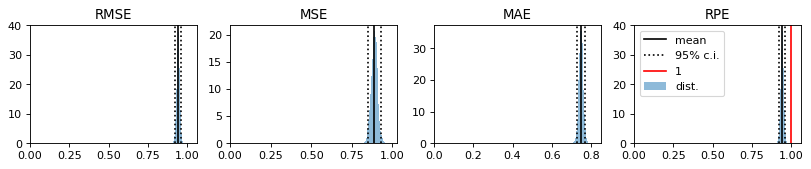

In [19]:
fig,ax = plt.subplots(1,4,dpi=80,figsize=(10,2),constrained_layout=True)
ax[0].hist(rmse,100,alpha=0.5,density=True);
ax[0].axvline(result_dict['rmse_mean'],color='k')
ax[0].axvline(result_dict['rmse_95CI'][0],color='k',linestyle=':')
ax[0].axvline(result_dict['rmse_95CI'][1],color='k',linestyle=':')
ax[0].set_xlim(0,1.1*np.percentile(rmse,99))
ax[0].set_title('RMSE')
ax[1].hist(mse,100,alpha=0.5,density=True);
ax[1].axvline(result_dict['mse_mean'],color='k')
ax[1].axvline(result_dict['mse_95CI'][0],color='k',linestyle=':')
ax[1].axvline(result_dict['mse_95CI'][1],color='k',linestyle=':')
ax[1].set_xlim(0,1.1*np.percentile(mse,99))
ax[1].set_title('MSE')
ax[2].hist(mae,100,alpha=0.5,density=True);
ax[2].axvline(result_dict['mae_mean'],color='k')
ax[2].axvline(result_dict['mae_95CI'][0],color='k',linestyle=':')
ax[2].axvline(result_dict['mae_95CI'][1],color='k',linestyle=':')
ax[2].set_xlim(0,1.1*np.percentile(mae,99))
ax[2].set_title('MAE')
ax[3].hist(rpe,100,alpha=0.5,density=True,label='dist.');
ax[3].axvline(result_dict['rpe_mean'],color='k',label='mean')
ax[3].axvline(result_dict['rpe_95CI'][0],color='k',linestyle=':',label='95% c.i.')
ax[3].axvline(result_dict['rpe_95CI'][1],color='k',linestyle=':')
ax[3].axvline(1.0,color='r',label='1')
ax[3].legend(loc=0)
ax[3].set_xlim(0,1.1*np.percentile(rpe,99))
ax[3].set_title('RPE')


In [17]:
masked_idx = rpe[~np.isnan(rpe)].argmax()
np.arange(n_test_samples)[~np.isnan(rpe)][masked_idx]

4483